In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tscv import GapRollForward
from tqdm.notebook import tqdm

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score

DATA_FILEPATH = '../data/sa/merged.csv'
OBS_PER_DAY = 24
X_EXCLUDE = ['datetime', 'net_load', 'total_load']

HOLIDAY_FILEPATH = '../data/australian-public-holidays-combined-2021-2024.csv'
holiday_df = pd.read_csv(HOLIDAY_FILEPATH, dtype='str')
holiday_df['Date'] = holiday_df['Date'].astype('datetime64[ns]')
holidays = holiday_df.loc[holiday_df['Jurisdiction'] == 'sa', ['Date', 'Holiday Name']]

obs = np.arange(1000) * OBS_PER_DAY
TRAIN_BEGIN, TEST_BEGIN = '2021-01-01', '2023-01-01'
TRAIN_MIN_SIZE = obs[366]
TRAIN_MAX_SIZE = obs[366]
TEST_MIN_SIZE = obs[7]
TEST_MAX_SIZE = obs[7]
ROLL_SIZE = obs[70]

df = pd.read_csv(DATA_FILEPATH)
df['datetime'] = df['datetime'].astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['dow'] = dt.day_of_week
df['week'] = dt.isocalendar().week
df['holiday'] = dt.date.isin(holidays['Date'].dt.date).astype('int')

X_cols = np.setdiff1d(df.columns.values, X_EXCLUDE)
X_ind = sorted(df.columns.get_indexer_for(X_cols))
y_ind = df.columns.get_loc('net_load')

train_ind = df['datetime'].between(TRAIN_BEGIN, TEST_BEGIN)
test_ind = df['datetime'] > TEST_BEGIN
X_train, y_train = df.loc[train_ind, X_cols], df.loc[train_ind, 'net_load']
X_test, y_test = df.loc[test_ind, X_cols], df.loc[test_ind, 'net_load']

In [14]:
from sklearn.model_selection import GridSearchCV

tscv = GapRollForward(
    min_train_size=TRAIN_MIN_SIZE, 
    max_train_size=TRAIN_MAX_SIZE,
    min_test_size=TEST_MIN_SIZE, 
    max_test_size=TEST_MAX_SIZE,
    roll_size=ROLL_SIZE
)

pipe = Pipeline([
    ('imputer', KNNImputer()), ('scaler', StandardScaler()), 
    ('kernel', Nystroem(n_jobs=-1)), ('sgd', SGDRegressor())
])

gamma_range = np.logspace(-9, 3, 13)
search = GridSearchCV(pipe, 
        param_grid={'kernel__gamma': gamma_range, 'kernel__n_components': [100, 1000]}, 
        n_jobs=-1, cv=tscv, verbose=3, refit=True)

search.fit(X_train, y_train)
search.best_score_, search.best_params_

Fitting 6 folds for each of 26 candidates, totalling 156 fits


[CV 1/6] END kernel__gamma=1e-09, kernel__n_components=100;, score=-0.319 total time=   0.3s
[CV 2/6] END kernel__gamma=1e-09, kernel__n_components=100;, score=-0.056 total time=   0.2s
[CV 3/6] END kernel__gamma=1e-09, kernel__n_components=100;, score=-0.061 total time=   0.4s
[CV 4/6] END kernel__gamma=1e-09, kernel__n_components=100;, score=-0.913 total time=   1.2s
[CV 5/6] END kernel__gamma=1e-09, kernel__n_components=100;, score=-0.149 total time=   1.0s
[CV 1/6] END kernel__gamma=1e-08, kernel__n_components=100;, score=-0.313 total time=   0.3s
[CV 2/6] END kernel__gamma=1e-08, kernel__n_components=100;, score=-0.047 total time=   0.3s
[CV 6/6] END kernel__gamma=1e-09, kernel__n_components=100;, score=-0.175 total time=   1.2s
[CV 3/6] END kernel__gamma=1e-08, kernel__n_components=100;, score=-0.074 total time=   0.4s
[CV 4/6] END kernel__gamma=1e-08, kernel__n_components=100;, score=-0.880 total time=   1.1s
[CV 5/6] END kernel__gamma=1e-08, kernel__n_components=100;, score=-0.

/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/6] END kernel__gamma=0.0001, kernel__n_components=100;, score=0.372 total time=  10.1s
[CV 2/6] END kernel__gamma=0.0001, kernel__n_components=100;, score=0.348 total time=  10.0s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/6] END kernel__gamma=0.0001, kernel__n_components=100;, score=0.416 total time=   8.9s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/6] END kernel__gamma=0.0001, kernel__n_components=100;, score=-0.138 total time=   9.6s
[CV 6/6] END kernel__gamma=1e-05, kernel__n_components=1000;, score=-0.108 total time=  21.4s
[CV 3/6] END kernel__gamma=1e-05, kernel__n_components=1000;, score=-0.003 total time=  27.9s
[CV 4/6] END kernel__gamma=1e-05, kernel__n_components=1000;, score=-0.770 total time=  26.5s
[CV 2/6] END kernel__gamma=1e-05, kernel__n_components=1000;, score=0.001 total time=  33.6s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/6] END kernel__gamma=0.0001, kernel__n_components=100;, score=0.377 total time=  10.6s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 6/6] END kernel__gamma=0.0001, kernel__n_components=100;, score=0.600 total time=  10.7s
[CV 5/6] END kernel__gamma=1e-05, kernel__n_components=1000;, score=-0.065 total time=  36.9s
[CV 1/6] END kernel__gamma=0.001, kernel__n_components=100;, score=0.632 total time=   4.9s
[CV 2/6] END kernel__gamma=0.001, kernel__n_components=100;, score=0.605 total time=   5.1s
[CV 3/6] END kernel__gamma=0.001, kernel__n_components=100;, score=0.624 total time=   8.6s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/6] END kernel__gamma=1e-05, kernel__n_components=1000;, score=-0.189 total time=  59.3s
[CV 4/6] END kernel__gamma=0.001, kernel__n_components=100;, score=0.241 total time=   5.9s
[CV 5/6] END kernel__gamma=0.001, kernel__n_components=100;, score=0.486 total time=   5.7s
[CV 6/6] END kernel__gamma=0.001, kernel__n_components=100;, score=0.758 total time=   4.9s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/6] END kernel__gamma=0.0001, kernel__n_components=1000;, score=0.002 total time=  56.6s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/6] END kernel__gamma=0.0001, kernel__n_components=1000;, score=0.346 total time=  56.7s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/6] END kernel__gamma=0.0001, kernel__n_components=1000;, score=0.416 total time=  56.7s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/6] END kernel__gamma=0.0001, kernel__n_components=1000;, score=-0.139 total time=  57.3s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/6] END kernel__gamma=0.0001, kernel__n_components=1000;, score=0.374 total time=  57.4s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 6/6] END kernel__gamma=0.0001, kernel__n_components=1000;, score=0.601 total time=  57.3s
[CV 1/6] END kernel__gamma=0.001, kernel__n_components=1000;, score=-0.651 total time=  32.3s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/6] END kernel__gamma=0.01, kernel__n_components=100;, score=-1.561 total time=   8.6s
[CV 2/6] END kernel__gamma=0.001, kernel__n_components=1000;, score=0.606 total time=  31.1s
[CV 2/6] END kernel__gamma=0.01, kernel__n_components=100;, score=0.745 total time=   8.6s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/6] END kernel__gamma=0.01, kernel__n_components=100;, score=0.625 total time=   8.2s
[CV 4/6] END kernel__gamma=0.01, kernel__n_components=100;, score=0.532 total time=   7.0s
[CV 5/6] END kernel__gamma=0.01, kernel__n_components=100;, score=0.453 total time=   8.3s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 6/6] END kernel__gamma=0.01, kernel__n_components=100;, score=0.739 total time=   9.2s
[CV 5/6] END kernel__gamma=0.001, kernel__n_components=1000;, score=0.505 total time=  27.2s
[CV 4/6] END kernel__gamma=0.001, kernel__n_components=1000;, score=0.247 total time=  31.8s
[CV 6/6] END kernel__gamma=0.001, kernel__n_components=1000;, score=0.766 total time=  37.1s
[CV 1/6] END kernel__gamma=0.1, kernel__n_components=100;, score=-0.361 total time=   7.2s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/6] END kernel__gamma=0.001, kernel__n_components=1000;, score=0.624 total time=  55.1s
[CV 2/6] END kernel__gamma=0.1, kernel__n_components=100;, score=0.547 total time=   6.0s
[CV 3/6] END kernel__gamma=0.1, kernel__n_components=100;, score=0.639 total time=   8.2s
[CV 4/6] END kernel__gamma=0.1, kernel__n_components=100;, score=0.219 total time=   6.1s
[CV 6/6] END kernel__gamma=0.1, kernel__n_components=100;, score=0.325 total time=   6.8s
[CV 5/6] END kernel__gamma=0.1, kernel__n_components=100;, score=0.663 total time=   9.0s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/6] END kernel__gamma=0.01, kernel__n_components=1000;, score=-1.459 total time=  51.5s
[CV 3/6] END kernel__gamma=0.01, kernel__n_components=1000;, score=0.631 total time=  51.9s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/6] END kernel__gamma=0.01, kernel__n_components=1000;, score=0.771 total time=  54.7s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/6] END kernel__gamma=0.01, kernel__n_components=1000;, score=0.563 total time=  55.5s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/6] END kernel__gamma=0.01, kernel__n_components=1000;, score=0.472 total time=  55.4s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 6/6] END kernel__gamma=0.01, kernel__n_components=1000;, score=0.725 total time=  55.2s
[CV 2/6] END kernel__gamma=1.0, kernel__n_components=100;, score=-0.042 total time=   2.4s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/6] END kernel__gamma=1.0, kernel__n_components=100;, score=-0.330 total time=   8.8s
[CV 4/6] END kernel__gamma=1.0, kernel__n_components=100;, score=-0.844 total time=   3.7s
[CV 3/6] END kernel__gamma=1.0, kernel__n_components=100;, score=-0.068 total time=   6.8s
[CV 6/6] END kernel__gamma=1.0, kernel__n_components=100;, score=-0.169 total time=   5.8s
[CV 5/6] END kernel__gamma=1.0, kernel__n_components=100;, score=-0.128 total time=   8.1s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/6] END kernel__gamma=0.1, kernel__n_components=1000;, score=0.810 total time=  54.7s
[CV 1/6] END kernel__gamma=0.1, kernel__n_components=1000;, score=-0.490 total time=  54.9s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/6] END kernel__gamma=0.1, kernel__n_components=1000;, score=0.751 total time=  54.7s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/6] END kernel__gamma=0.1, kernel__n_components=1000;, score=0.821 total time=  55.2s
[CV 4/6] END kernel__gamma=0.1, kernel__n_components=1000;, score=0.472 total time=  56.0s
[CV 1/6] END kernel__gamma=10.0, kernel__n_components=100;, score=-0.325 total time=   0.3s
[CV 2/6] END kernel__gamma=10.0, kernel__n_components=100;, score=-0.063 total time=   0.3s
[CV 3/6] END kernel__gamma=10.0, kernel__n_components=100;, score=-0.080 total time=   0.3s
[CV 4/6] END kernel__gamma=10.0, kernel__n_components=100;, score=-0.830 total time=   0.9s
[CV 5/6] END kernel__gamma=10.0, kernel__n_components=100;, score=-0.154 total time=   1.0s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 6/6] END kernel__gamma=0.1, kernel__n_components=1000;, score=0.530 total time=  55.2s
[CV 6/6] END kernel__gamma=10.0, kernel__n_components=100;, score=-0.196 total time=   1.2s
[CV 1/6] END kernel__gamma=10.0, kernel__n_components=1000;, score=-0.344 total time=   8.5s
[CV 2/6] END kernel__gamma=10.0, kernel__n_components=1000;, score=-0.057 total time=   9.7s
[CV 3/6] END kernel__gamma=10.0, kernel__n_components=1000;, score=-0.075 total time=   6.6s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/6] END kernel__gamma=1.0, kernel__n_components=1000;, score=-0.273 total time=  55.8s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/6] END kernel__gamma=1.0, kernel__n_components=1000;, score=0.059 total time=  55.2s
[CV 1/6] END kernel__gamma=100.0, kernel__n_components=100;, score=-0.333 total time=   1.0s
[CV 2/6] END kernel__gamma=100.0, kernel__n_components=100;, score=-0.054 total time=   0.8s
[CV 3/6] END kernel__gamma=100.0, kernel__n_components=100;, score=-0.068 total time=   0.6s
[CV 4/6] END kernel__gamma=100.0, kernel__n_components=100;, score=-0.878 total time=   1.2s
[CV 5/6] END kernel__gamma=100.0, kernel__n_components=100;, score=-0.140 total time=   1.1s
[CV 6/6] END kernel__gamma=100.0, kernel__n_components=100;, score=-0.186 total time=   1.2s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/6] END kernel__gamma=1.0, kernel__n_components=1000;, score=0.008 total time=  55.1s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/6] END kernel__gamma=1.0, kernel__n_components=1000;, score=-0.802 total time=  55.7s
[CV 1/6] END kernel__gamma=100.0, kernel__n_components=1000;, score=-0.349 total time=  14.9s
[CV 5/6] END kernel__gamma=10.0, kernel__n_components=1000;, score=-0.152 total time=  29.5s
[CV 4/6] END kernel__gamma=10.0, kernel__n_components=1000;, score=-0.851 total time=  35.2s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/6] END kernel__gamma=1.0, kernel__n_components=1000;, score=-0.012 total time=  55.5s
[CV 1/6] END kernel__gamma=1000.0, kernel__n_components=100;, score=-0.320 total time=   0.2s
[CV 2/6] END kernel__gamma=1000.0, kernel__n_components=100;, score=-0.058 total time=   0.3s
[CV 3/6] END kernel__gamma=1000.0, kernel__n_components=100;, score=-0.058 total time=   0.3s
[CV 4/6] END kernel__gamma=1000.0, kernel__n_components=100;, score=-0.824 total time=   0.8s
[CV 5/6] END kernel__gamma=1000.0, kernel__n_components=100;, score=-0.135 total time=   1.1s
[CV 6/6] END kernel__gamma=1000.0, kernel__n_components=100;, score=-0.198 total time=   1.1s


/Users/chase/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 6/6] END kernel__gamma=1.0, kernel__n_components=1000;, score=-0.009 total time=  55.2s
[CV 2/6] END kernel__gamma=1000.0, kernel__n_components=1000;, score=-0.066 total time=   5.8s
[CV 2/6] END kernel__gamma=100.0, kernel__n_components=1000;, score=-0.064 total time=  14.9s
[CV 6/6] END kernel__gamma=10.0, kernel__n_components=1000;, score=-0.178 total time=  35.9s
[CV 5/6] END kernel__gamma=100.0, kernel__n_components=1000;, score=-0.152 total time=  18.3s
[CV 4/6] END kernel__gamma=1000.0, kernel__n_components=1000;, score=-0.836 total time=  10.7s
[CV 6/6] END kernel__gamma=100.0, kernel__n_components=1000;, score=-0.190 total time=  24.2s
[CV 6/6] END kernel__gamma=1000.0, kernel__n_components=1000;, score=-0.189 total time=   9.7s
[CV 3/6] END kernel__gamma=100.0, kernel__n_components=1000;, score=-0.070 total time=  31.3s
[CV 1/6] END kernel__gamma=1000.0, kernel__n_components=1000;, score=-0.343 total time=  26.6s
[CV 4/6] END kernel__gamma=100.0, kernel__n_components=1000

(0.5576142982039061, {'kernel__gamma': 0.001, 'kernel__n_components': 100})

In [15]:
pred = search.predict(X_test)
((y_test - pred) / y_test).abs().mean()

0.20987481580175263

<Axes: xlabel='datetime', ylabel='value'>

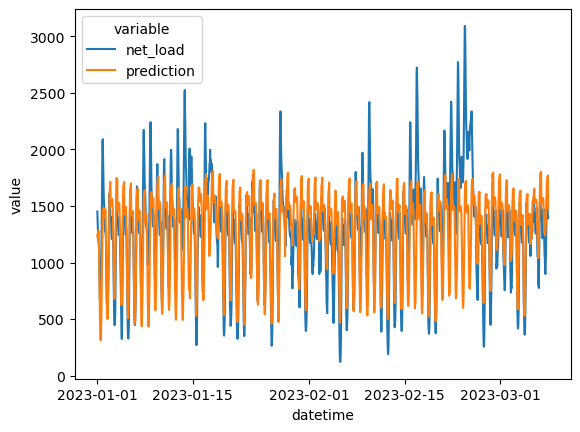

In [16]:
pred_df = df.loc[test_ind,:].copy()
pred_df['prediction'] = pred
plot_df = pred_df.melt(id_vars='datetime', value_vars=['net_load', 'prediction'])
sns.lineplot(plot_df, x='datetime', y='value', hue='variable')